In [5]:
import fenics as fn
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from dolfin_utils.meshconvert import meshconvert
import os
from subprocess import call
import datetime


In [6]:

def curl2D(v):
    return as_vector((v.dx(1),-v.dx(0)))

class FEM():
            
    def __init__(self,J0=1000.0,mu0=1.0,mur=1/100.0, k1=0.001, k2=1.65, k3 = 0.5, meshsize = 0.001, verb = False):
        path='./'
        
        with open(path + 'quad.geo', 'r') as file:
            data = file.read()
            
        s = "meshsize=%.18f;\n"%(meshsize)
        
        s = s + data
        
        with  open(path+"tmp.geo", "w") as file:
            file.write(s)
            file.close()
        if verb: print('geo file created',flush = True)
        
        if verb:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 '%(path,path))
        else:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 >/dev/null 2>&1'%(path,path))
        if verb: print('mesh file created',flush=True)

        if verb:
            os.system('dolfin-convert %stmp.msh %stmp.xml'%(path,path))
        else:
            os.system('dolfin-convert %stmp.msh %stmp.xml >/dev/null 2>&1'%(path,path))
        
        if verb: print('mesh file converted in fenics format',flush=True) 

        mesh = fn.Mesh(path+'tmp.xml')
        domains = fn.MeshFunction("size_t", mesh, path+'tmp_physical_region.xml')
        boundaries = fn.MeshFunction('size_t', mesh, path+'tmp_facet_region.xml')

        ncells = [  mesh.num_vertices(), mesh.num_edges(), mesh.num_faces(), mesh.num_facets(), mesh.num_cells() ]
        
        def nu_lin(az):
            return mu0*mur
        def nonlin_nu(az):
            tmp =  k1*exp(k2*dot(az.dx(1),az.dx(1)))+k3
            return tmp
        
        def nu_Bauer(B):
            x = dot(B,B)
            return k1*exp(k2*x)+k3
        
        # Coil
        def setup_coil(mesh,subdomains):
            DG = FunctionSpace(mesh,"DG",0)
            J = Function(DG)
            idx = []
            for cell_no in range(len(subdomains.array())):
                subdomain_no = subdomains.array()[cell_no]
                if subdomain_no == 3:
                    idx.append(cell_no)
            J.vector()[:] = 0
            J.vector()[idx] = J0
            return J
        
       
        
        
        mesh = Mesh(path +"tmp.xml")
        boundaries = MeshFunction("size_t", mesh, path + "tmp_facet_region.xml")
        domains    = MeshFunction("size_t", mesh, path + "tmp_physical_region.xml")
        ncells = [  mesh.num_vertices(), mesh.num_edges(), mesh.num_faces(), mesh.num_facets(), mesh.num_cells() ]
        self.mesh = mesh
        
        """ define function space and boundary conditions"""
        
        CG = FunctionSpace(mesh, 'CG', 1) # Continuous Galerkin
        
        # Define boundary condition
        bc = DirichletBC(CG, Constant(0.0), boundaries,1)
        
        # Define subdomain markers and integration measure
        dx = Measure('dx', domain=mesh, subdomain_data=domains)
        
        J = setup_coil(mesh, domains)
        
        class Nu(UserExpression): # UserExpression instead of Expression
            def __init__(self, markers, **kwargs):
                super().__init__(**kwargs) # This part is new!
                self.markers = markers
            def eval_cell(self, values, x, cell):
                if self.markers[cell.index] == 1:
                    values[0] = 0.0   # iron
                elif self.markers[cell.index] == 2:
                    values[0] = 1/mu0      # air
                elif self.markers[cell.index] == 3:
                    values[0] = 1/mu0      # air
                else:
                    print('no such domain',self.markers[cell.index] )
                    
        nus = Nu(domains, degree=1)
        
        
        """ weak formulation """
        
        az  = Function(CG)
        u  = Function(CG)
        v  = TestFunction(CG)
        #az = Function(CG)
        #a  = (1/mu)*dot(grad(az), grad(v))*dx
        a = inner(nus*curl2D(u), curl2D(v))*dx + inner(nu_lin(curl2D(u))*curl2D(u),curl2D(v))*dx(1)
        L  = J*v*dx(3)
        
        F = a - L
        # solve variational problem
        tme = datetime.datetime.now()
        solve(F == 0, u, bc)
        tme = datetime.datetime.now() - tme
        print(tme)
        az = u
        self.az = az
        # function space for H- and B- field allocated on faces of elements
        W = VectorFunctionSpace(mesh, FiniteElement("DP", triangle, 0),1)
        B = project(curl2D(az), W)
        H = None# project((1/mu)*curl(az), W)
        self.B = B
        self.H = H
    
    def call_A(self,x_eval,y_eval):
        
        
        Afem = 0 * x_eval
        for i in range(x_eval.size):
            try:
                Afem[i] = self.az(x_eval[i],y_eval[i])
            except:
                Afem[i] = np.nan
        return Afem
    
    def call_B(self,x_eval,y_eval):
        
        
        Bfem = []
        for i in range(x_eval.size):
            try:
                Bfem.append(self.B(x_eval[i],y_eval[i]))
            except:
                Bfem.append([ np.nan , np.nan])
        return np.array(Bfem)
    
    def call_H(self,x_eval,y_eval):
        Hfem = []
        for i in range(x_eval.size):
            try:
                Hfem.append(self.H(x_eval[i],y_eval[i]))
            except:
                Hfem.append([ np.nan , np.nan])
        return np.array(Hfem)

J0 = 5511505.854152553
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.279e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
0:00:00.322571
  Newton iteration 1: r (abs) = 7.173e-15 (tol = 1.000e-10) r (rel) = 5.609e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 10979 nodes for 5490 points.


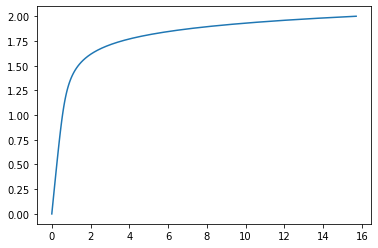

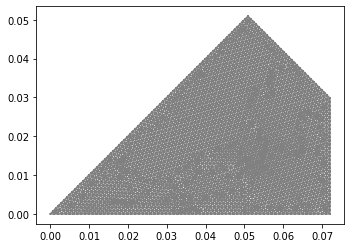

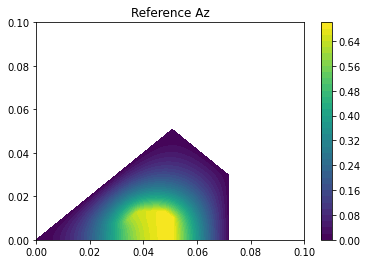

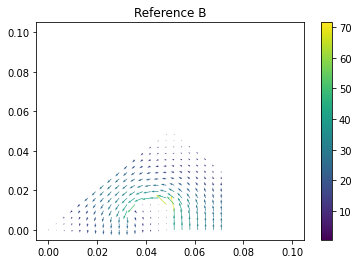

/home/yonnss/.local/lib/python3.10/site-packages/matplotlib/quiver.py:671: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/yonnss/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


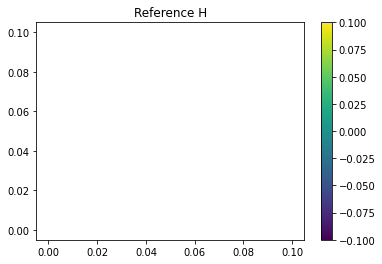

In [7]:


S=1
x_mesh, y_mesh = np.meshgrid(np.linspace(0,0.1,200)*S,np.linspace(0,0.1,200)*S)
area = 0.0002177263404511999*S*S
J0 = 50/area *24
print('J0 =',J0)
fem = FEM()

k1 = 0.01
k2 = 1.65
k3 = 0.5
B = np.linspace(0,2,100)  
nu = lambda x : k1*np.exp(k2*x*x)+k3 
H = nu(B) * B 

plt.figure()
plt.plot(H,B)

A_ref = fem.call_A(x_mesh.flatten(),y_mesh.flatten()).reshape(x_mesh.shape)

# plt.figure()
# plt.contourf(x_mesh,y_mesh,A,levels=64)
# plt.colorbar()
# plt.title('NN result')

plt.figure()
fn.plot(fem.mesh)

plt.figure()
plt.contourf(x_mesh,y_mesh,A_ref,levels=42)
plt.colorbar()
plt.title('Reference Az')

x_mesh, y_mesh = np.meshgrid(np.linspace(0,0.1,32)*S,np.linspace(0,0.1,32)*S)

B_ref = fem.call_B(x_mesh.flatten(),y_mesh.flatten())
H_ref = fem.call_H(x_mesh.flatten(),y_mesh.flatten())

plt.figure()
plt.quiver(x_mesh.flatten(),y_mesh.flatten(),B_ref[:,0],B_ref[:,1],np.sqrt(B_ref[:,0]**2+B_ref[:,1]**2))
plt.colorbar()
plt.title('Reference B')

plt.figure()
plt.quiver(x_mesh.flatten(),y_mesh.flatten(),H_ref[:,0],H_ref[:,1],np.sqrt(H_ref[:,0]**2+H_ref[:,1]**2))
plt.colorbar()
plt.title('Reference H')

plt.show()
# plt.figure()
# plt.contourf(x_mesh,y_mesh,A-A_ref,levels=64)
# plt.colorbar()
# plt.title('Error')

# np.save('../pinns/quad_A_ref.dat',A_ref)
